## Profiler Code

In [1]:
%pip install --quiet pandas matplotlib psutil pynvml

Note: you may need to restart the kernel to use updated packages.


In [2]:

import time
import os
import pandas as pd
import threading
import psutil
from pynvml import *
from typing import List, Dict
import matplotlib.pyplot as plt

class ResourceMonitor:
    def __init__(self, interval=5, log_path=None, verbose=False):
        """
        Initialize the ResourceMonitor with optional log persistence.
        
        Args:
            interval (int): Time interval (in seconds) between resource checks
            log_path (str): Optional path to CSV file for saving/loading logs
            verbose: Whether to print events to console
        """
        self.interval = interval
        self.log_path = log_path
        self.verbose = verbose
        self.resource_log = []
        self.event_log = []
        self.monitoring = False
        self.thread = None
        
        self._log_event("SYSTEM", "ResourceMonitor initialized")
        # Load existing log if path is provided and file exists
        if self.log_path and os.path.exists(self.log_path):
            self.load_log(silent=True)

    def _log_gpu(self):
        """
        Log GPU usage using NVIDIA Management Library (NVML).
        
        Returns:
            dict: GPU memory usage and utilization. Returns zeros if no GPU is available.
        """
        try:
            nvmlInit()
            handle = nvmlDeviceGetHandleByIndex(0)
            mem_info = nvmlDeviceGetMemoryInfo(handle)
            util_info = nvmlDeviceGetUtilizationRates(handle)
            return {
                'gpu_mem_GB': mem_info.used / (1024 ** 3),
                'gpu_util_percent': util_info.gpu
            }
        except NVMLError as e:
            self._log_event("GPU", f"NVML error: {str(e)}. Possibly no Nvidia GPUs present in the system", is_error=True)
            return {
                'gpu_mem_GB': 0.0,
                'gpu_util_percent': 0.0
            }
        finally:
            try:
                nvmlShutdown()
            except:
                pass

    def _log_resources(self):
        """
        Log system resources (CPU, RAM, GPU) at regular intervals.
        """
        while self.monitoring:
            memory = psutil.virtual_memory().used / (1024 ** 3)  # RAM in GB
            cpu_percent = psutil.cpu_percent()
            gpu_stats = self._log_gpu()

            # Append resource usage to log
            self.resource_log.append({
                'timestamp': time.time(),
                'memory_GB': memory,
                'cpu_percent': cpu_percent,
                **gpu_stats
            })
            time.sleep(self.interval)

    def _log_event(self, category, message, is_error=False):
        """Internal method to log system events"""
        event = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "category": category,
            "message": message,
            "error": is_error
        }
        self.event_log.append(event)
        
        if self.verbose:
            status = "ERROR" if is_error else "INFO"
            print(f"[{event['timestamp']}] [{status}] {category}: {message}")


    def save_log(self, path: str = None) -> None:
        """Save metric logs to CSV"""
        try:
            save_path = path or self.log_path
            if not save_path:
                raise ValueError("No save path specified")
            
            # Ensure the directory exists
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            if os.path.exists(save_path):
                self._log_event("IO", f"File already exists: {save_path}. Overwriting.", is_error=False)
            
            df = self.get_logs()
            df.to_csv(save_path, index=False)
            self._log_event("IO", f"Saved {len(df)} entries to {save_path}")
            
        except Exception as e:
            self._log_event("ERROR", f"Save failed: {str(e)}", is_error=True)
            raise


    def load_log(self, path: str = None, silent: bool = False) -> None:
        """Load metric logs from CSV"""
        try:
            load_path = path or self.log_path
            if not load_path:
                raise ValueError("No load path specified")

            if os.path.exists(load_path):
                df = pd.read_csv(load_path, parse_dates=['timestamp'])
                self.resource_log = df.to_dict('records')
                msg = f"Loaded {len(df)} entries from {load_path}"
                self._log_event("IO", msg)
                if not silent:
                    print(msg)  # Always print load confirmation unless silent=True
            else:
                msg = f"File not found: {load_path}"
                self._log_event("IO", msg, is_error=True)
                if not silent:
                    print(msg)
                    
        except Exception as e:
            self._log_event("ERROR", f"Load failed: {str(e)}", is_error=True)
            raise


    def start(self, append_log=False):
        """
        Start resource monitoring.
        
        Args:
            append_log (bool): Whether to append to existing logs (False overwrites)
        """
        try:
            if self.monitoring:
                self._log_event("MONITOR", "Monitoring already in progress", is_error=True)
                raise RuntimeError("Monitoring already in progress")
            
            action = "Appending to" if append_log else "Starting new"
            self._log_event("MONITOR", f"{action} log session")

            if not append_log:
                self.resource_log.clear()
                self._log_event("DATA", "Existing logs cleared")

            self.monitoring = True
            self.thread = threading.Thread(target=self._log_resources, daemon=True)
            self.thread.start()
            self._log_event("THREAD", "Monitoring thread started")
        except Exception as e:
            self._log_event("ERROR", f"Start failed: {str(e)}", is_error=True)
            raise


    def stop(self) -> None:
        """Stop resource monitoring"""
        try:
            if self.monitoring:
                self.monitoring = False
                if self.thread is not None:
                    self.thread.join()
                    self._log_event("THREAD", "Monitoring thread stopped")
                self._log_event("MONITOR", "Stopped successfully")
            else:
                self._log_event("MONITOR", "Stop requested but not running", is_error=True)
                raise RuntimeError("Monitoring not running")
        except Exception as e:
            self._log_event("ERROR", f"Stop failed: {str(e)}", is_error=True)
            raise

    
    def get_event_log(self, filter_category: str = None) -> List[Dict]:
        """Retrieve event log with optional filtering"""
        if filter_category:
            return [e for e in self.event_log if e['category'] == filter_category]
        return self.event_log.copy()


    def get_last_event(self) -> Dict:
        """Get the most recent event"""
        return self.event_log[-1] if self.event_log else {}


    def print_event_log(self, max_events: int = 10) -> None:
        """Print recent events in readable format"""
        for event in self.event_log[-max_events:]:
            status = "ERROR" if event['error'] else "INFO"
            print(f"[{event['timestamp']}] [{status}] {event['category']}: {event['message']}")

    def get_logs(self):
        """
        Get the logged resource data as a pandas DataFrame.
        
        Returns:
            pd.DataFrame: Logged resource data.
        """
        df = pd.DataFrame(self.resource_log)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        return df

    def visualize_logs(self):
        """
        Visualize the logged resource data as time-series plots.
        """
        df = self.get_logs()

        if df.empty:
            print("No data to visualize.")
            return

        fig, ax = plt.subplots(3, 1, figsize=(12, 8))
        
        # Plot RAM usage
        df.plot(x='timestamp', y='memory_GB', ax=ax[0], title='RAM Usage (GB)', color='blue')
        
        # Plot CPU utilization
        df.plot(x='timestamp', y='cpu_percent', ax=ax[1], title='CPU Utilization (%)', color='orange')
        
        # Plot GPU memory usage and utilization
        df.plot(x='timestamp', y='gpu_mem_GB', ax=ax[2], title='GPU Memory Usage (GB)', color='green')
        
        plt.tight_layout()
        plt.show()

    def summarize_logs(self):
        """
        Summarize the logged resource data with key statistics.
        
        Returns:
            dict: Summary statistics of resource usage.
        """
        df = self.get_logs()
        
        if df.empty:
            print("No data to summarize.")
            return {}

        stats = {
            'Max RAM (GB)': df.memory_GB.max(),
            'Avg RAM (GB)': df.memory_GB.mean(),
            'Peak CPU (%)': df.cpu_percent.max(),
            'Max GPU Mem (GB)': df.gpu_mem_GB.max(),
            'Avg GPU Util (%)': df.gpu_util_percent.mean()
        }
        
        return stats

## Load Dataset

In [24]:
%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")

df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

df = pd.concat([df_train, df_test], ignore_index=True)

Note: you may need to restart the kernel to use updated packages.


## Load Model & Tokenizer

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
token = hf_token

try:
    login(token=token)
    print("Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

HF_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
print("Loaded Tokenizer")
base_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=3)    
print("Loaded Model")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Logged in to Hugging Face Hub


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Loaded Tokenizer


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model


#### Tokenize Text (Split + Encode)

In [15]:
# Setting the pad token. By default, LLaMA models do not have a pad token, so we need to set it manually.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    # padding set make the batches equal to the value set in max_length 
    # truncation set to True to truncate the text if it exceeds max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

type(tokenized_datasets["train"])
# dataset = tokenized_datasets["train"] + tokenized_datasets["test"]


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 3534
    })
})


datasets.arrow_dataset.Dataset

## Inference

[2025-04-09 09:07:32] [INFO] SYSTEM: ResourceMonitor initialized
[2025-04-09 09:07:32] [INFO] MONITOR: Appending to log session
[2025-04-09 09:07:32] [INFO] THREAD: Monitoring thread started
Base model response: positive
Base model prediction: Positive
True label: Positive
Base model response: negative
Base model prediction: Negative
True label: Neutral
Base model response: negative
Base model prediction: Negative
True label: Negative


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Base model response: negative
Base model prediction: Negative
True label: Negative
Base model response: positive
Base model prediction: Positive
True label: Positive
Base model response: negative
Base model prediction: Negative
True label: Negative
Base model response: positive
Base model prediction: Positive
True label: Positive
Base model response: negative
Base model prediction: Negative
True label: Negative
Base model response: neutral
Base model prediction: Neutral
True label: Positive
Base model response: negative
Base model prediction: Negative
True label: Negative
Base model response: neutral

the sentiment of this tweet is neutral.
Base model prediction: Neutral
True label: Negative
Base model response: positive
Base model prediction: Positive
True label: Positive
Base model response: positive
Base model prediction: Positive
True label: Positive
Base model response: negative
Base model prediction: Negative
True label: Negative
Base model response: negative
Base model predictio

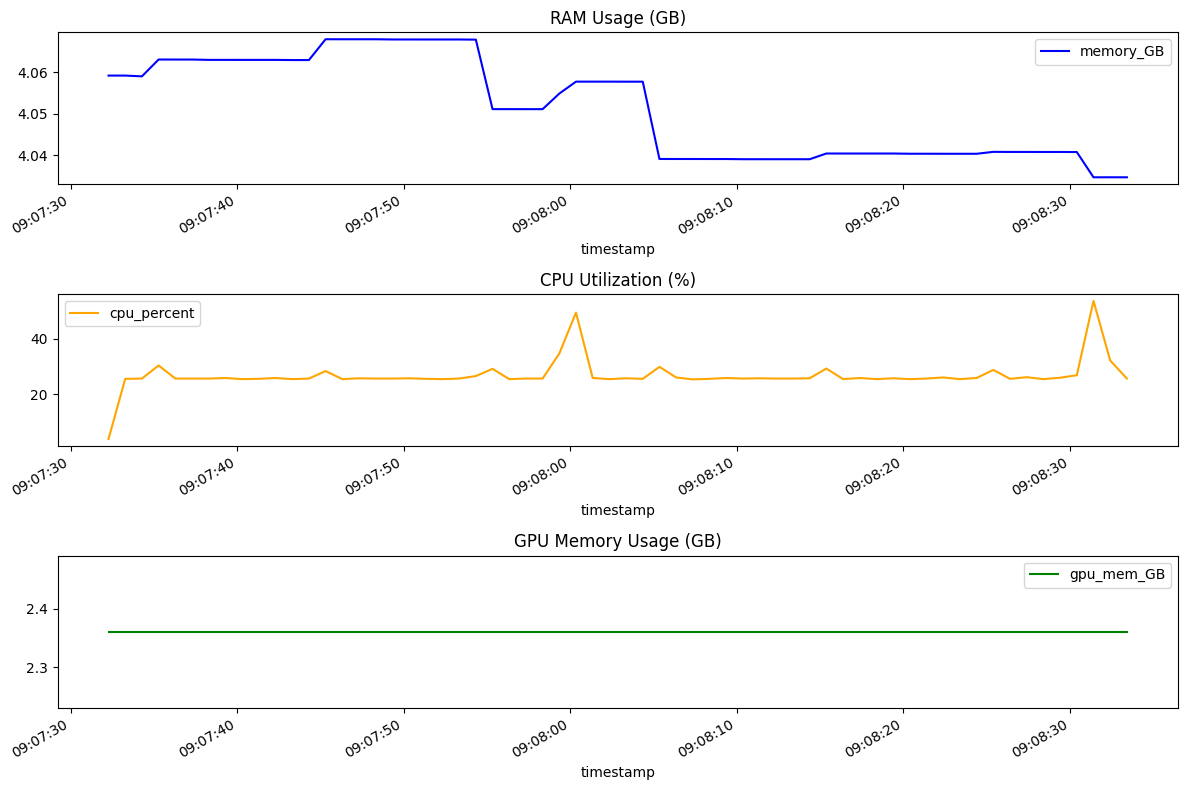

{'Max RAM (GB)': 4.068035125732422,
 'Avg RAM (GB)': 4.051280913814422,
 'Peak CPU (%)': 53.6,
 'Max GPU Mem (GB)': 2.3612060546875,
 'Avg GPU Util (%)': 49.24193548387097}

In [10]:
import random
sample_indices = random.sample(range(len(small_eval_dataset)), 1000)
import torch

# Keep reference to the base LLM model if it exists, otherwise load it
if 'base_llm' not in locals():
    print("Loading base LLM model for examples...")
    from transformers import AutoModelForCausalLM
    base_llm = AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME)
    base_llm.to("cuda" if torch.cuda.is_available() else "cpu")
    base_llm.eval()

# Map numerical labels to text
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

resource_monitor = ResourceMonitor(interval=1, verbose=True)
resource_monitor.start(append_log=True)

for idx in sample_indices:
    example = small_eval_dataset[idx]
    text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    true_label = example['label']
    
    # Create prompt for base model
    prompt = f"""Classify the sentiment of this tweet as either positive, negative, or neutral.
Tweet: "{text}"
Sentiment:"""

    # Get prediction from base model using zero-shot prompting
    inputs = tokenizer(prompt, return_tensors="pt").to(base_llm.device)
    
    with torch.no_grad():
        outputs = base_llm.generate(
            inputs.input_ids,
            max_new_tokens=10,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode and interpret base model response
    base_response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip().lower()
    
    # Get base model prediction from response text
    if "positive" in base_response:
        base_pred = 2
    elif "negative" in base_response:
        base_pred = 0
    elif "neutral" in base_response:
        base_pred = 1
    else:
        # Default to neutral if unclear
        base_pred = 1

    print(f"Base model response: {base_response}")
    print(f"Base model prediction: {label_map[base_pred]}")
    print(f"True label: {label_map[true_label]}")

resource_monitor.stop()
resource_monitor.save_log("kaggle/working/resource_log.csv")
resource_monitor.visualize_logs()
resource_monitor.summarize_logs()



In [11]:
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:
    base_model(inputs)
    
print(prof.key_averages().table(
    sort_by="self_cuda_memory_usage", 
    row_limit=20
))

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not BatchEncoding